In [1]:
using Pkg
#Pkg.add("RigidBodyDynamics")
#Pkg.add("MeshCat")
#Pkg.add("MeshCatMechanisms")
#Pkg.add("StaticArrays")
#Pkg.add("Rotations")
#Pkg.add("ForwardDiff")
#Pkg.add("FiniteDiff")
#Pkg.add("Quaternions")
#Pkg.add("OSQP")
#Pkg.add("Plots")
#Pkg.add("Colors")
#Pkg.add("MathOptInterface")
#Pkg.add("Ipopt")
include(joinpath(@__DIR__, "humanoid.jl"))
include(joinpath(@__DIR__, "ball_qp.jl"))
include(joinpath(@__DIR__, "../src/utils/fmincon.jl"))
using LinearAlgebra
import ForwardDiff as FD

WebIO._IJuliaInit()

## Finding Robot Balancing Pose

In [2]:
model = G1Humanoid()

const x_guess = initial_state(model) # our guess state for balancing
mvis = initialize_visualizer(model) # visualizer 
set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
render(mvis)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_yaw_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_hip_yaw_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c,

In [3]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default

    α = 1
    for i = 1:max_ls_iters
        
        if (merit_fx(z + α * Δz) < merit_fx(z))
            return α
        end
        α = α / 2
        
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # Computes Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    for i = 1:(max_iters - 1)        
        r = res_fx(Z[i]) 
        
        norm_r = norm(r) 
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        Δz = -1 *  res_jac_fx(Z[i]) \ res_fx(Z[i])
        
        α = linesearch(Z[i], Δz, merit_fx)

        Z[i+1] = Z[i] .+ α*Δz

        if verbose
            print("α: $α \n")
        end
        
    end
    error("Newton's method did not converge")
end
function merit(z)
    # merit function
    r = kkt(z)
    return norm(r[1:94]) + 1e4*norm(r[94:end])
end

merit (generic function with 1 method)

In [4]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:64
const idx_u = 65:93
const idx_c = 94:157

function cost(y::Vector)
    x = y[idx_x]
    u = y[idx_u]
    
    return 1/2 * (x - x_guess)' * (x - x_guess) + 1/2 * 1e-3*u'*u
end
function constraint(y::Vector)::Vector
    x = y[idx_x]
    u = y[idx_u]
    
    return dynamics(model, x, u)
end
function kkt(z::Vector)::Vector
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    s = FD.gradient(cost, y) + FD.jacobian(constraint, y)' * λ
    
    pf = constraint(y)
    return [s; pf]
end

function kkt_jac(z::Vector)::Matrix
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    H = FD.hessian(cost, y)
    C = FD.jacobian(constraint, y)
    J = [
        H C';
        C zeros(size(λ, 1), size(λ, 1))
    ]

    β = 1e-3
    reg = [I(size(y, 1)) zeros(size(C')); zeros(size(C)) I(size(λ, 1))]

    return J + β * reg
    
end
   
    
z0 = [x_guess; zeros(29); zeros(64)]
Z = newtons_method(z0, kkt, kkt_jac, merit; tol = 1e-6, verbose = false, max_iters = 50)
# visualizer 
set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
u_eq = Z[end][idx_u]
x_eq = Z[end][idx_x]
x_dot = dynamics(model, x_eq, u_eq)
@assert norm(x_dot, Inf) < 1e-6
println("Equilibrium found! $(norm(x_dot, Inf))")
render(mvis)

Equilibrium found! 6.042441813128359e-12


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_yaw_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_hip_yaw_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c,

## Ball Dynamics, Calculating Kick Point

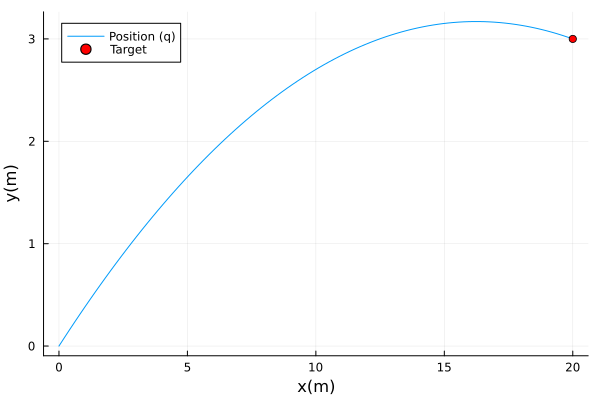

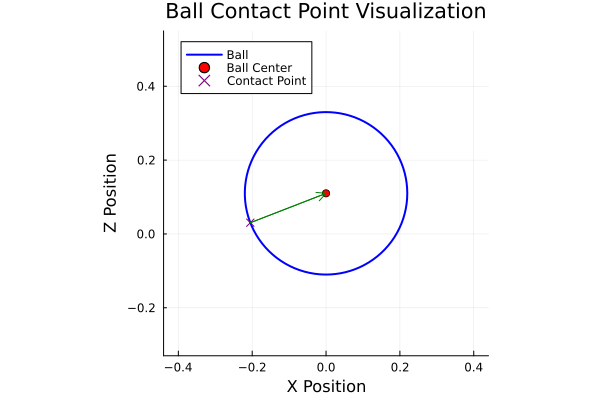

In [5]:
q_i = [0.0, 0.0] # Note, this is in the X-Z Plane only, y value will be assigned manually after the fact
q_des = [20.0, 3.0]
J = optimize_impulse(q_des, q_i) # Can also specify mass
dynamics_rollout(J, q_des, q_i)
p_c = get_contact_point(J) # Can also specify radius of ball
visualize_contact(J, p_c)

## Calculating Kick Trajectory

In [8]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    model = params.model
    x1dot = dynamics(model, x1, u)
    x2dot = dynamics(model, x2, u)
    x_k12 = 1/2 * (x1 + x2) + dt/8 * (x1dot - x2dot)
    return x1 + dt/6 * (x1dot + 4 * dynamics(model, x_k12, u) + x2dot) - x2
end
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

create_idx (generic function with 1 method)

In [9]:
function cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
        
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 1/2 * (xi-xg)'*Q*(xi-xg) + 1/2 * ui'*R*ui
    end
    
    J += 1/2 * (Z[idx.x[N]] - xg)' * Qf * (Z[idx.x[N]] - xg)
    return J 
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
        #c[idx.c[i]] = linearized_dynamics(params, xi, ui) - xip1

    end
    return c 
end

function equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg, u_eq = params.N, params.idx, params.xic, params.xg, params.u_eq#, params.kick_point, params.kick_vel

    # TODO: figure out which state variables correspond to right ankle joint and position (and lock angle joint)
    # and make it kick the ball at the desired point with the desired velocity
    # if doing linear model, x_actual = x_eq + x
    
    return [Z[idx.x[1]] - xic; Z[idx.x[N]] - xg; Z[idx.u[1]] - u_eq; Z[idx.u[N-1]] - u_eq; dynamics_constraints(params, Z)]
end

equality_constraint (generic function with 1 method)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    39250
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Exception of type: TOO_FEW_DOF in file "Interfaces/IpIpoptApplication.cpp" at line 662:
 Exception message: status != TOO_FEW_DEGREES_OF_FREEDOM evaluated false: Too few degrees of freedom (rethrown)!

EXIT: Problem has too few degrees of freedom.


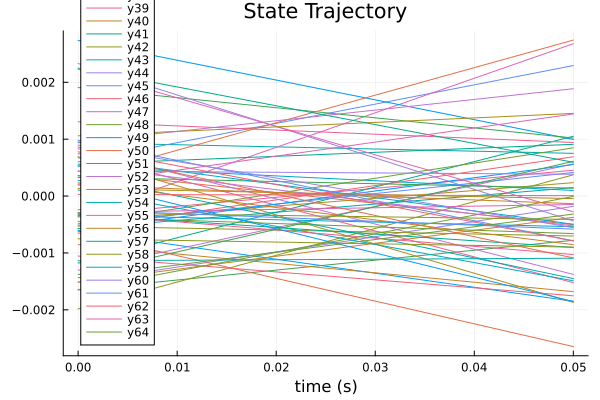

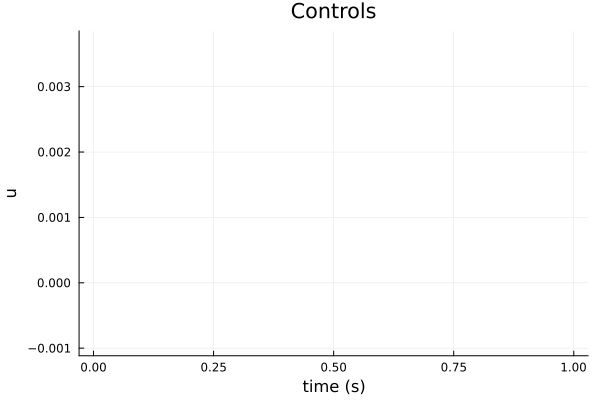

In [11]:
function solve_ball_kick(;verbose=true)
    
    # problem size 
    nx = size(x_eq, 1)
    nu = size(u_eq, 1)
    dt = 0.05
    tf = 0.05
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = 0.1 * diagm(ones(nx))
    R = 0.1 * diagm(ones(nu))
    Qf = 10 * diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = 1 * x_eq
    xg = 1 * x_eq

    Ac = FD.jacobian(x_ -> dynamics(model, x_, u_eq), x_eq)
    Bc = FD.jacobian(u_ -> dynamics(model, x_eq, u_), u_eq)
    matrix_exp = exp([Ac Bc; zeros(nu, nx) zeros(nu, nu)] .* dt)
    A = matrix_exp[1:nx, 1:nx]
    B = matrix_exp[1:nx, nx+1:end]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5, u_eq = zeros(size(u_eq)), model=model, A = A, B = B)

    # TODO: add joint limits
    x_l = -Inf * ones(idx.nz)
    x_u = Inf * ones(idx.nz)
    #
    #for i = 1:N-1
    #    x_l[params.idx.u[i]] .= -10
    #    x_u[params.idx.u[i]] .= 10
    #end

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    #diff_type = :auto 
    diff_type = :finite
    
    
    Z = fmincon(cost,equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

    
X, U, t_vec = solve_ball_kick(verbose=true)
    
    
Xm = hcat(X...)
Um = hcat(U...)
    
# --------------plotting-----------------
display(plot(t_vec, Xm', xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
    
# meshcat animation
#display(animate_cartpole(X, 0.05))